In [1]:
import os
import sys
from IPython.display import Markdown, display, Image
import numpy as np
import pandas as pd
import random
import math
import dvc.api
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from helper import Helper
from app_logger import App_Logger
import plots
from sklearn import preprocessing
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
helper = Helper()

In [19]:
train_df = helper.read_csv("../data/train.csv")
store_df = helper.read_csv("../data/store.csv")
test_df = helper.read_csv("../data/test.csv")

file read as csv
file read as csv
file read as csv


In [5]:
class CleanTrainData:
   
    def __init__(self):
        pass
    
    def to_numeric(self, df):
        df["Customers"] = df["Customers"].astype("int")
        df["Sales"] = df["Sales"].astype("int")
        return df
        
    def to_category(self, df):
        
        df["Open"] = df["Open"].astype("category")
        df["DayOfWeek"] = df["Open"].astype("category")
        df["Promo"] = df["Promo"].astype("category")
        df["StateHoliday"] = df["StateHoliday"].astype("category")
        df["SchoolHoliday"] = df["SchoolHoliday"].astype("category")
        df['StateHoliday'] = df['StateHoliday'].astype("str").astype("category")
        return df
    
    def drop_closed_stores(self, df):
        
        try:
            cleaned = df.query("Open == 1")
            return cleaned
        except:
            pass
        
    def convert_to_datatime(self, df):  
        try:
            df['Date'] = pd.to_datetime(train_df['Date'])
            return df
        except:
            pass
    
    def sort_by_date(self, df):
        return df.sort_values(by=["Date"], ascending=False)     
    
        
    def get_cleaned(self, df):
        df = self.to_category(df)
        df = self.to_numeric(df)
#         df = self.drop_closed_stores(df)
        df = self.convert_to_datatime(df)

        return df

In [6]:
class CleanStoreDf:
    """ This is a class to clean store df"""
    
    def __init__(self):
        pass
    
    def handle_missing_value(self, df):
        """We handled CompetitionDistance by replacing it with median"""
        
        
        df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].max())
        df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(df['Promo2SinceWeek'].max())
        df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(df['Promo2SinceWeek'].max())
        df['PromoInterval'] = df['PromoInterval'].fillna(df['PromoInterval'].mode()[0])
        df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].mode()[0])
        df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].mode()[0])    
        
        return df
    
    
    def to_numeric(self, df):
        
        df["CompetitionDistance"] = df["CompetitionDistance"].astype("float")
        df["Promo2SinceWeek"] = df["Promo2SinceWeek"].astype("int")
        return df
    
    def to_category(self, df):
        
        df["StoreType"] = df["StoreType"].astype("category")
        df["Assortment"] = df["Assortment"].astype("category")
        df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].astype("category")
        df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].astype("category")
        
        df["Promo2"] = df["Promo2"].astype("category")
        
        df["Promo2SinceYear"] = df["Promo2SinceYear"].astype("category")
        df["PromoInterval"] = df["PromoInterval"].astype("category")
        
        return df
    
        
    def get_cleaned(self, df):
        df = self.handle_missing_value(df)
        df = self.to_category(df)
        df = self.to_numeric(df)
        return df
             

In [7]:
class PreprocessRossmanData:
    
    def __init__(self):
        pass
    
        
    def handle_outliers(self, df, col, method="lower_upper"):
        
        df = df.copy()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        lower_bound = q1 - ((1.5) * (q3 - q1))
        upper_bound = q3 + ((1.5) * (q3 - q1))

        if method == "mean":
            df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

        elif  method == "mode":
            df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
        else:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        return df
    
    def transform_date(self, df):
        
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = pd.DatetimeIndex(df['Date']).year
        df['Month'] = pd.DatetimeIndex(df['Date']).month
        df['Day'] = pd.DatetimeIndex(df['Date']).day
        
        df['Year'] = df['Year'].astype("category")
        df['Month'] = df['Month'].astype("category")
        df['Day'] = df['Day'].astype("category")
        df['DayInMonth'] = df['Day'].apply(lambda x: self.to_month_category(x))
        df['DayInMonth'] =  df['DayInMonth'].astype("category")
        return df
    
    def to_month_category(self, value):
        try:
            if (value >= 1 and int(value) < 10):
                return "BegMonth"

            elif (value >= 10 and value < 20):
                return "MidMonth"
            else:
                return "EndMonth"
        except:
            pass
    
    def add_weekday_col(self, df):
      
        df["Weekends"] = df["DayOfWeek"].apply(lambda x: 1 if x > 5 else 0)
        df["Weekends"] = df["Weekends"].astype("category")
        return df
    
    def encode_train_data(self, df):
        
        StateHolidayEncoder = preprocessing.LabelEncoder()
        DayInMonthEncoder = preprocessing.LabelEncoder()
        
        df['StateHoliday'] = StateHolidayEncoder.fit_transform(df['StateHoliday'])
        df['DayInMonth'] = DayInMonthEncoder.fit_transform(df['DayInMonth'])
        return df
        
    def encode_store_data(self, df):
        StoreTypeEncoder = preprocessing.LabelEncoder()
        AssortmentEncoder = preprocessing.LabelEncoder()
        PromoIntervalEncoder = preprocessing.LabelEncoder()

        
#         PromoInterval
        df['StoreType'] = StoreTypeEncoder.fit_transform(df['StoreType'])
        df['Assortment'] = AssortmentEncoder.fit_transform(df['Assortment'])
        df['PromoInterval'] = PromoIntervalEncoder.fit_transform(df['PromoInterval'])

        return df
    
    def merge_encoded(self, train_enc, store_enc):
        return pd.merge(train_enc, store_enc, on="Store")
    
    def process(self, train_df, store_df):
        
#         enc_train = self.encode_train_data(train_df)
#         enc_store = self.encode_store_data(store_df)
        
#         enc_train = enc_train.drop(columns=["Date"], axis=1)
        
        train_df = self.transform_date(train_df)
        train_df = self.add_weekday_col(train_df)
        
        train_df = self.handle_outliers(train_df, "Sales")
        train_df = self.handle_outliers(train_df, "Customers")

        store_df = self.handle_outliers(store_df, "CompetitionDistance")
        
        
        merged = self.merge_encoded(train_df, store_df)
#         sclaed = helper.scaler(merged, merged.columns.to_list(), mode="standard")
        
        return merged
    
        
        

In [8]:
clean_train_df = CleanTrainData().get_cleaned(train_df)
clean_store_df = CleanStoreDf().get_cleaned(store_df)
cleaned_rossman_data = PreprocessRossmanData().process(clean_train_df, clean_store_df)

In [9]:
def loss_function(actual, pred):
    mae = mean_absolute_error(actual, pred)
    return mae

class RossmanModelPipeline:
    
    def __init__(self, cleaned_rossman_data, model_name):  
       
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(cleaned_rossman_data)
        self.model_name = model_name
    
    def prepare_data(self, cleaned_rossman_data):
        feat_cols = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','Year', 'Open',
                     'Month','Day','Weekends','StoreType','Assortment','CompetitionDistance',
                     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                     'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', "DayInMonth"]
        
        X = cleaned_rossman_data[feat_cols]
        y = cleaned_rossman_data["Sales"]
        return train_test_split(X, y, test_size=0.2)
    
    def Preproccessor(self):  
        cols = self.X_train.columns
        numric_cols = ["CompetitionDistance", "Promo2SinceWeek"]
        categorical_cols = self.X_train.drop(columns=numric_cols, index=1, inplace=False).columns.to_list()
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
        
        preprocessor = ColumnTransformer(
            transformers=[('numric', numeric_transformer, numric_cols),
                          ('category', categorical_transformer, categorical_cols)])
        return preprocessor
    
    def train(self, regressor=RandomForestRegressor(n_jobs=-1, n_estimators=15)):
        preprocessor = self.Preproccessor()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', regressor)])
        
#         mlflow.set_experiment('Rossman-' + self.model_name)
#         mlflow.sklearn.autolog()
#         with mlflow.start_run(run_name="Baseline"):
        model = pipeline.fit(self.X_train, self.y_train)
                
        return pipeline, model
    
    
    def test(self, model):
        
        predictions = model.predict(self.X_test)
        score_2 = r2_score(self.y_test, predictions)
        loss = loss_function(predictions, self.y_test)
        print(f" R2 score of model is: {score_2:.3f}")

        print(f"step Mean abs error of model is: {loss:.3f}")
        
        result_df = self.X_test.copy()
        result_df["Prediction Sales"] = predictions
        result_df["Actual Sales"] = self.y_test
        result_agg = result_df.groupby("Day").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
        return score_2, loss, result_agg
 
    
    def pred_graph(self, res_dataframe):
        
        fig = plt.figure(figsize=(18, 5))
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel="Day", fontsize=16)
        plt.ylabel(ylabel="Sales", fontsize=16)
        plt.show()
        
        return fig
    
    def get_feature_importance(self, model):
        if (type(model.steps[1][1]) == type(LinearRegression())):
            model = model.steps[1][1]
            denom = (2.0*(1.0+np.cosh(model._decision_function(self.X_train))))
            denom = np.tile(denom,(self.X_train.shape[1],1)).T
            F_ij = np.dot((self.X_train/denom).T,self.X_train) ## Fisher Information Matrix
            Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
            sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
            z_scores = model.coef_[0]/sigma_estimates # z-score 
            p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
            p_df = pd.DataFrame()
            p_df['features'] = self.X_train.columns.to_list()
            p_df['p_values'] = p_values
            
            return p_df
        
        importance = model.steps[1][1].feature_importances_
        f_df = pd.DataFrame(columns=["features", "importance"])
        f_df["features"] = self.X_train.columns.to_list()
        f_df["importance"] = importance
        return f_df

In [10]:
rossPipeLine = RossmanModelPipeline(cleaned_rossman_data, "RandomForset-2")
pipeline, model = rossPipeLine.train()

 R2 score of model is: 0.910
step Mean abs error of model is: 700.151


,Prediction Sales,Actual Sales
Day,,
1,4597.385191,4592.799805
2,6832.158410,6864.942342
3,5748.257676,5701.661646
4,6699.033594,6747.952707
5,6322.884833,6305.338739
6,5877.376690,5844.263694
7,5979.859545,5998.532260
8,5625.429095,5599.647499
9,5280.930977,5244.574011


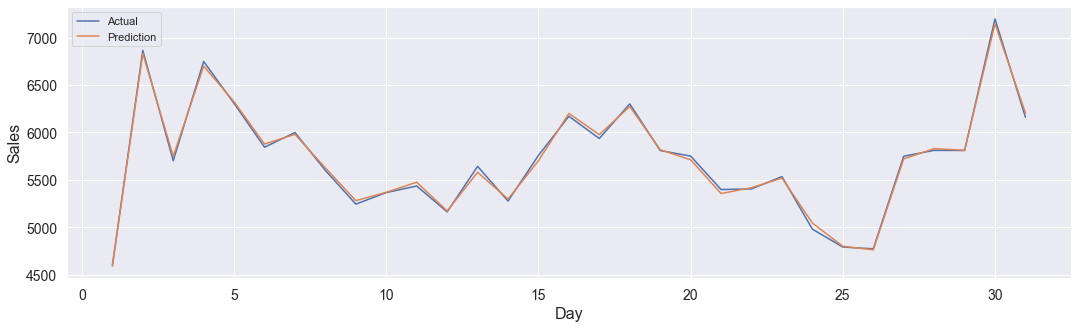

In [11]:
score, loss, res_df = rossPipeLine.test(model)
display(res_df)
fig = rossPipeLine.pred_graph(res_df)

In [12]:
random_feat_imp = rossPipeLine.get_feature_importance(model).sort_values(by=["importance"], ascending=False)
display(random_feat_imp)

,features,importance
2,StateHoliday,0.309303
7,Day,0.206309
0,DayOfWeek,0.122099
3,SchoolHoliday,0.076349
9,StoreType,0.047266
14,Promo2,0.046286
13,CompetitionOpenSinceYear,0.046175
8,Weekends,0.037783
1,Promo,0.023835
11,CompetitionDistance,0.023552


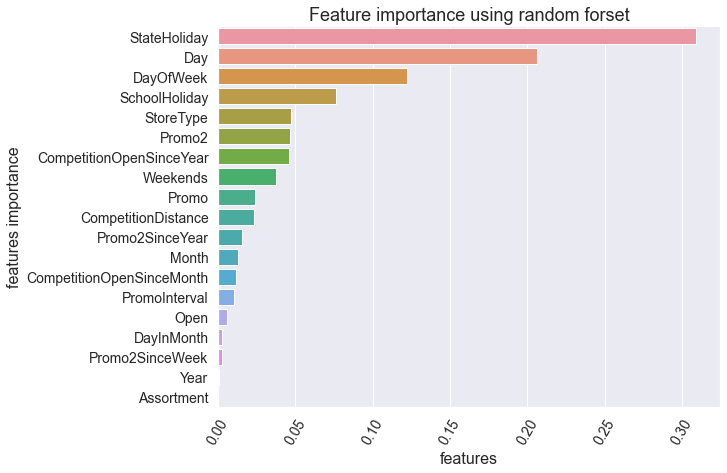

In [13]:
plots.plot_bar(random_feat_imp,  "importance", "features","Feature importance using random forset", "features",
               "features importance")

In [14]:
import datetime
timestamp = str(datetime.datetime.now())

In [15]:
rossPipeLine_2 = RossmanModelPipeline(cleaned_rossman_data, "LinearRegression")
pipeline_2, model_2 = rossPipeLine_2.train(regressor= LinearRegression())

 R2 score of model is: 0.603
step Mean abs error of model is: 1683.367


,Prediction Sales,Actual Sales
Day,,
1,4218.253413,4479.395736
2,6306.933756,6843.457749
3,5628.675793,5686.886905
4,6538.857645,6666.374312
5,6347.408943,6275.840886
6,6063.146753,5837.390838
7,6103.915555,5960.278523
8,5849.653955,5705.587992
9,5373.811223,5205.154836


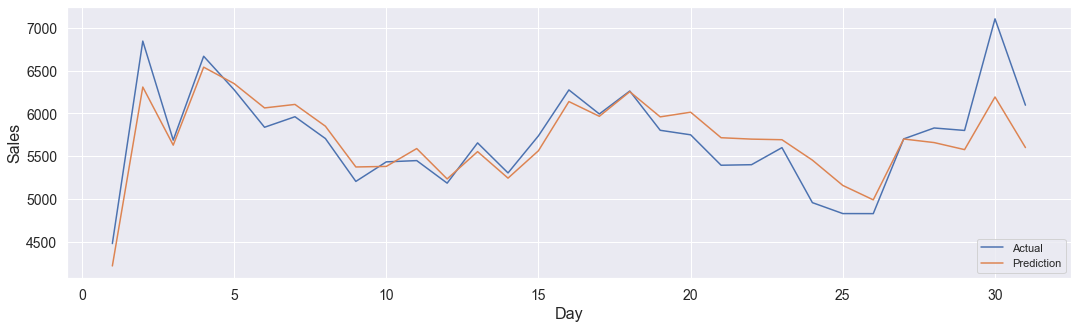

In [16]:
score_2, loss_2, res_df_2 = rossPipeLine_2.test(model_2)
display(res_df_2)
fig = rossPipeLine_2.pred_graph(res_df_2)

In [17]:
lr_feat_imp = rossPipeLine_2.get_feature_importance(model_2).sort_values(by=["importance"], ascending=False)
display(lr_feat_imp)

ValueError: could not convert string to float: 'a'

In [18]:
plots.plot_bar(lr_feat_imp,  "importance", "features","Feature importance using random forset", "features",
               "features importance")

NameError: name 'lr_feat_imp' is not defined